# **Proyecto Series de Tiempo**
*Candies production*


---


>**Name:**
*   Cruz Aguirre, Lilivette

## Dataset description

###Source: FRED

What is FRED?

Short for Federal Reserve Economic Data, FRED is an online database consisting of hundreds of thousands of economic data time series from scores of national, international, public, and private sources. FRED, created and maintained by the Research Department at the Federal Reserve Bank of St. Louis, goes far beyond simply providing data: It combines data with a powerful mix of tools that help the user understand, interact with, display, and disseminate the data. In essence, FRED helps users tell their data stories.

###Industrial Production: Manufacturing: Non-Durable Goods: Sugar and Confectionery Product

The dataset likely tracks the industrial production output of non-durable goods, providing information about the quantity of sugar and confectionery products manufactured over time.



*   **Sugar Products**: This category includes the manufacturing of various sugar-based products. It could involve the processing of raw sugar or sugar beets into refined sugar, as well as the production of sugar-based products like syrups, molasses, etc.
*   **Confectionery Products**: This category involves the manufacturing of confectionery items. Confectionery products are sweet food items, often categorized into candies, chocolates, chewing gum, and other sweets.

This kind of data can be valuable for analyzing trends in the food industry, understanding consumer preferences, and assessing economic activity related to the production of sweets.

**Characteristics**:

*   Units:  Index 2017=100
*   Not Seasonally Adjusted
*   Frequency:  Monthly

**Fields**:

*   Date: A field indicating the time period of the data point.

*   IP.G3113.N: The quantity or volume of sugar and confectionery products manufactured during the specified period. The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

## Carga de dataset

In [1]:
# @title Libraries
import pandas as pd
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error

# Profhet
import prophet

#Graphics
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from pandas.plotting import autocorrelation_plot

# pmdarima
from pmdarima import ARIMA
from pmdarima import auto_arima

# statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# ExponentialSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Linear regression
from sklearn.linear_model import LinearRegression

# skforecast
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from sklearn.metrics import mean_absolute_error

In [2]:
# @title Loading file
archivo_csv = 'candy_production.csv'
dataframe = pd.read_csv(archivo_csv)

In [3]:
# @title Formatting the data
candies= dataframe[['DATE','IPG3113N']]
candies.columns = ['Date', 'IP']

# Formatear columna Date a tipo fecha
candies['Date'] = pd.to_datetime(candies['Date'])

# Formatear columna IP a numeric
candies['IP'] = pd.to_numeric(candies['IP'], errors='coerce')

# Establecer la columna 'Date' como índice
candies.set_index('Date', inplace=True)

# Ordernar el dataset
candies = candies.sort_values(by='Date')

print(candies.head())

                 IP
Date               
1972-01-01  74.6385
1972-02-01  62.5554
1972-03-01  57.5046
1972-04-01  56.2333
1972-05-01  56.6197


In [4]:
# @title Validating total records

byDate = candies.groupby('Date').size().reset_index(name='Conteo')

print('Total records:', candies.shape[0])
print('Total different dates:', candies.shape[0])

Total records: 621
Total different dates: 621


In [5]:
# @title Describe dataset
candies.describe()

,IP
count,621.000000
mean,89.618371
std,16.086681
min,44.208900
25%,77.993600
50%,91.625000
75%,101.334200
max,129.272500


## Limpieza de datos

In [6]:
# @title Valores faltantes de IP (NaN)
missing_values = candies.isnull().sum()
print("Valores faltantes por columna:", missing_values)

if int(missing_values) > 0:
  candies = candies.dropna()
  print('Se elimnaron los valores faltantes')
else:
  print('No hay valores faltantes')

Valores faltantes por columna: IP    0
dtype: int64
No hay valores faltantes


In [7]:
# @title Outliers

# Calcular los cuartiles Q1 y Q3
Q1 = candies['IP'].quantile(0.25)
Q3 = candies['IP'].quantile(0.75)

# Calcular el rango intercuartílico (IQR)
IQR = Q3 - Q1

# Definir los límites para identificar outliers
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Identificar outliers
outliers = candies[(candies['IP'] < limite_inferior) | (candies['IP'] > limite_superior)]

# Resultados
print("Cuartil 1 (Q1):", Q1)
print("Cuartil 3 (Q3):", Q3)
print("IQR:", IQR)
print("Límite Inferior:", limite_inferior)
print("Límite Superior:", limite_superior)
print("Outliers:", outliers)


Cuartil 1 (Q1): 77.9936
Cuartil 3 (Q3): 101.3342
IQR: 23.340599999999995
Límite Inferior: 42.98270000000001
Límite Superior: 136.3451
Outliers: Empty DataFrame
Columns: [IP]
Index: []


## Inspección visual

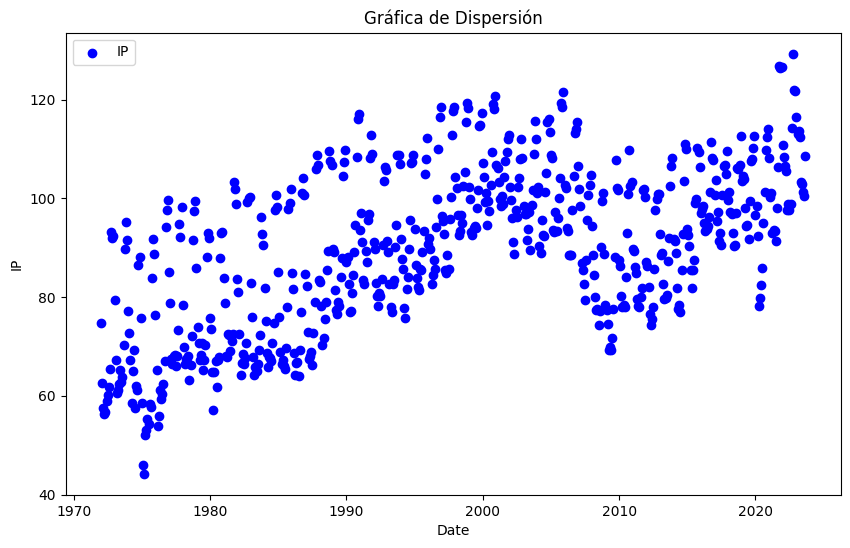

In [8]:
# @title  Gráfica de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(candies.index, candies['IP'], color='blue', label='IP')
plt.title('Gráfica de Dispersión')
plt.xlabel('Date')
plt.ylabel('IP')
plt.legend()
plt.show()


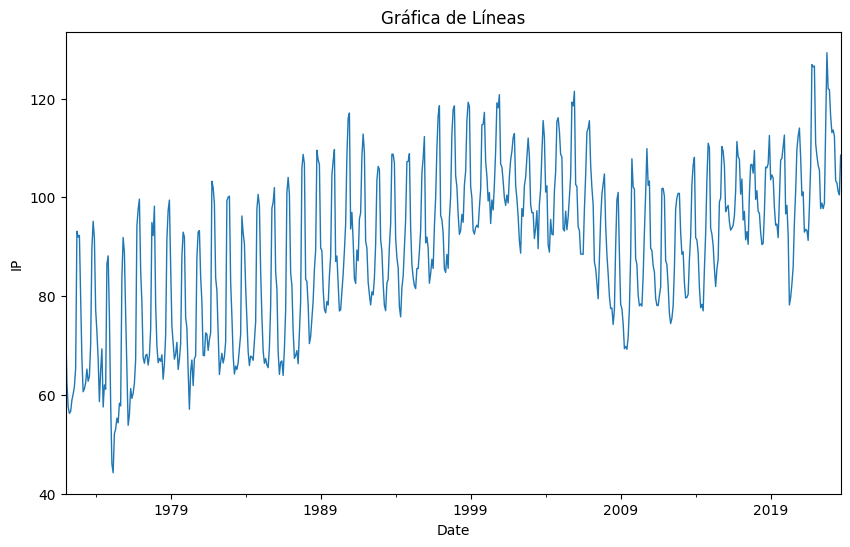

In [9]:
# @title  Gráfica de líneas
plt.figure(figsize=(10, 6))
candies['IP'].plot(linewidth=1)
plt.title('Gráfica de Líneas')
plt.xlabel('Date')
plt.ylabel('IP')
plt.show()

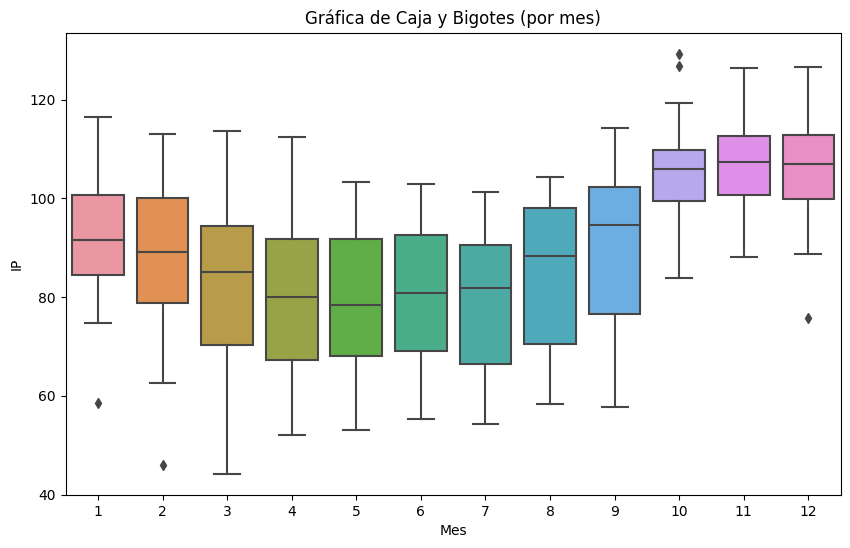

In [10]:
# @title  Gráfica de caja y bigotes
plt.figure(figsize=(10, 6))
sns.boxplot(x=candies.index.month, y='IP', data=candies)
plt.title('Gráfica de Caja y Bigotes (por mes)')
plt.xlabel('Mes')
plt.ylabel('IP')
plt.show()


**Observations**
The months with the highest candies production are October, November and December, the increase starts with Hallowen and continues with Christmas holidays and New Year’s Day.

Regarding the outliers, the peak in October is related to Hallowen. The jan and feb outliers are related to the new year resolution of losing weight.

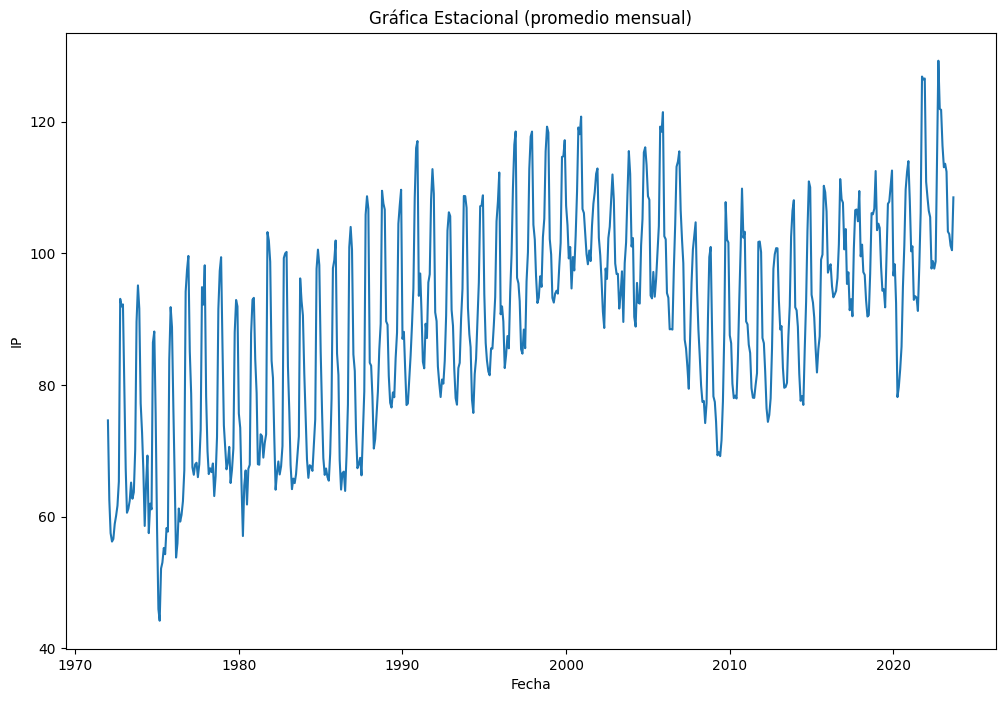

In [11]:
# @title  Gráfica estacional
plt.figure(figsize=(12, 8))
sns.lineplot(x=candies.index, y='IP', data=candies.resample('M').mean())
plt.title('Gráfica Estacional (promedio mensual)')
plt.xlabel('Fecha')
plt.ylabel('IP')
plt.show()



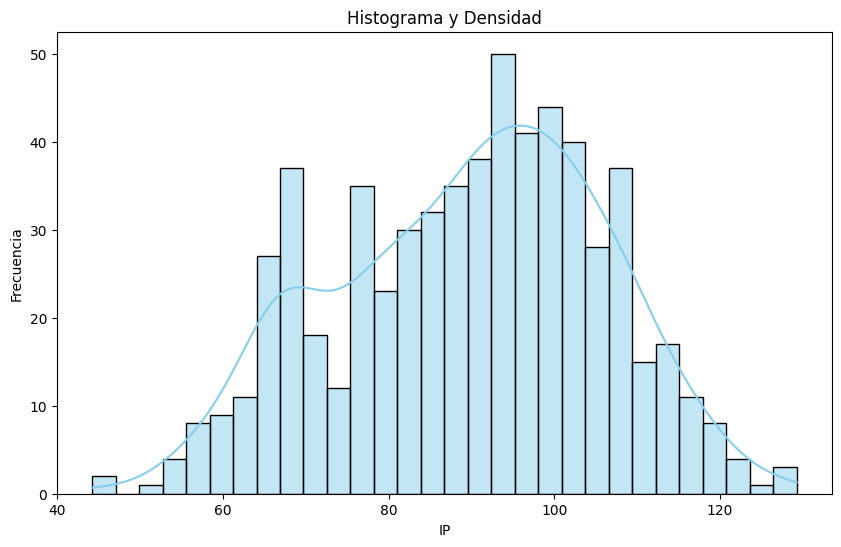

In [12]:
# @title  Histograma y densidad
#Cuando observas un histograma y una gráfica de densidad juntos, puedes obtener una visión más completa de la distribución de tus datos, incluidos detalles sobre la forma, simetría, sesgo y concentración. Si tienes alguna pregunta específica sobre tus gráficos o si puedes describir lo que ves, estaré encantado de ayudarte a interpretarlos.
plt.figure(figsize=(10, 6))
sns.histplot(candies['IP'], kde=True, bins=30, color='skyblue')
plt.title('Histograma y Densidad')
plt.xlabel('IP')
plt.ylabel('Frecuencia')
plt.show()

**Observations**
If looks like the distribution is bimodal. One corresponding with the increase of the production for the high season and the other with the
lower season.  

<Figure size 1200x600 with 0 Axes>

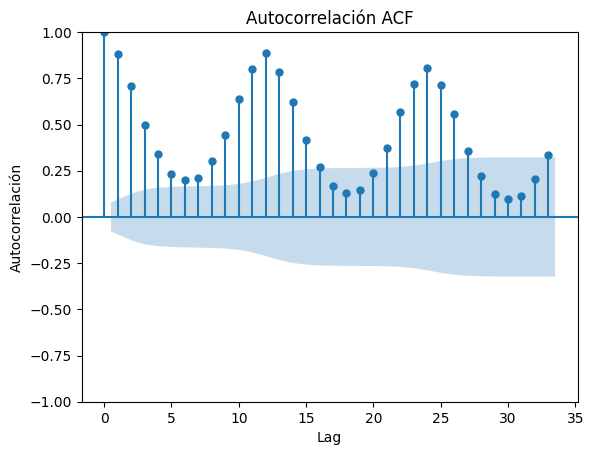

In [13]:
# @title  Autocorrelación ACF
plt.figure(figsize=(12, 6))
plot_acf(candies['IP'], lags=33, alpha=0.05)
plt.title('Autocorrelación ACF')
plt.xlabel('Lag')
plt.ylabel('Autocorrelación')
plt.show()


La ACF (AutoCorrelation Function) mide la correlación entre una serie temporal y versiones rezagadas (retardadas) de sí misma.

Observaciones: La gráfica decrece geometricamente y tiene forma de la función coseno. Hasta el lag 16 los valores están por encima de la línea de significancia lo que significa que 16 lags tienen una relación estadísticamente significativa con el valor de IP. Los picos están en los lags 12 y 24, lo cual comprueba la estacionalidad de los datos.


<Figure size 1200x600 with 0 Axes>

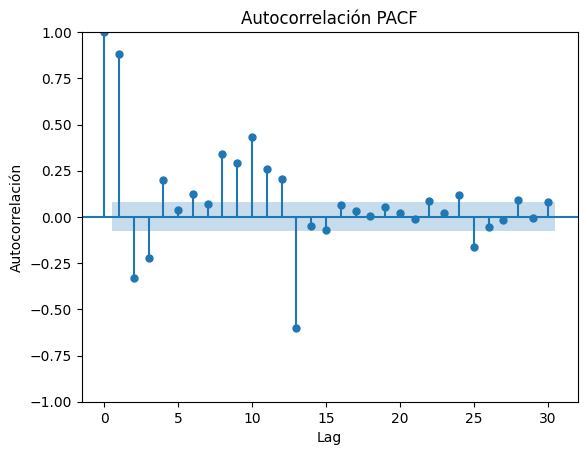

In [14]:
# @title  Autocorrelación PACF
plt.figure(figsize=(12, 6))
plot_pacf(candies['IP'], lags=30, alpha=0.05)
plt.title('Autocorrelación PACF')
plt.xlabel('Lag')
plt.ylabel('Autocorrelación')
plt.show()

La PACF (Partial AutoCorrelation Function) mide la correlación entre una observación y otra observación en un rezago particular, eliminando la influencia de los rezagos intermedios.

Observaciones: Los valores de la gráfica decaen lentamente, lo que indica estacionalidad en los datos. La estacionalidad se confirma con la presencia de un corte profundo en el lag 13 y 26, la periodicidad de los datos es anual.

## Descomposición de la serie

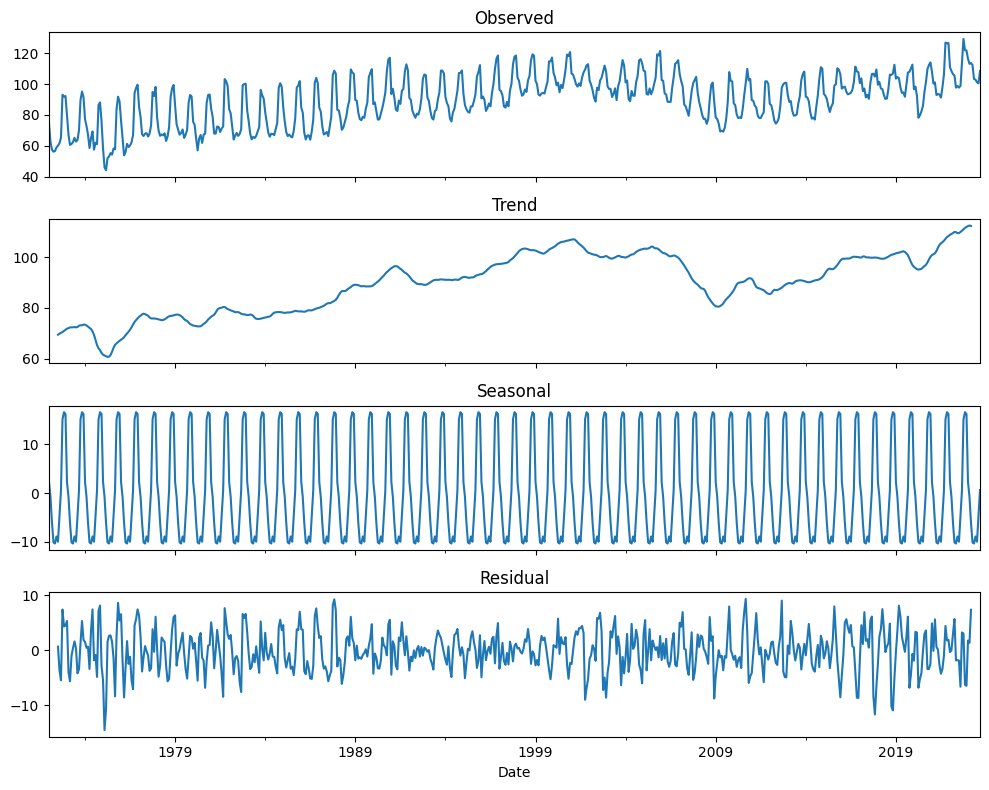

In [15]:
# Descomposición de la serie
result = seasonal_decompose(candies['IP'], model='additive', period=12)

# Graficar los componentes
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

result.observed.plot(ax=ax1, title='Observed')
result.trend.plot(ax=ax2, title='Trend')
result.seasonal.plot(ax=ax3, title='Seasonal')
result.resid.plot(ax=ax4, title='Residual')

plt.tight_layout()
plt.show()

**Observaciones:**

Tiene tendencia y estacionalidad.

## Flujo de prónostico

In [16]:
# @title Train y test
# Dividir los datos en entrenamiento y prueba
train_size = int(len(candies) * 0.7)
train, test = candies.iloc[:train_size], candies.iloc[train_size:]

In [17]:
def evaluate_model(model, test):
    predictions = model.predict(start=test.index[0], end=test.index[-1])
    rmse = sqrt(mean_squared_error(test['IP'], predictions))
    print(f'RMSE: {rmse}')
    return rmse

In [18]:
# @title Simple Moving Average (SMA)
sma_model = train['IP'].rolling(window=12).mean().iloc[-1]
sma_rmse = sqrt(mean_squared_error(test['IP'], np.full_like(test['IP'], sma_model)))
print(f'Simple Moving Average RMSE: {sma_rmse}')


Simple Moving Average RMSE: 12.920203240432752


In [19]:
# @title Último valor observado
loc_model = train['IP'].iloc[-1]
loc_rmse = sqrt(mean_squared_error(test['IP'], np.full_like(test['IP'], loc_model)))
print(f'Last Value RMSE: {loc_rmse}')

Last Value RMSE: 14.362608891807833


In [20]:
# @title Regresión Lineal
regression_model = LinearRegression()
regression_model.fit(train.index.values.reshape(-1, 1).astype(float), train['IP'])
regression_predictions = regression_model.predict(test.index.values.reshape(-1, 1).astype(float))
regression_rmse = sqrt(mean_squared_error(test['IP'], regression_predictions))
print(f'Regression RMSE: {regression_rmse}')

Regression RMSE: 22.814449800772426


In [21]:
# @title ETS (Error, Trend, Seasonal)
ets_model = ExponentialSmoothing(train['IP'], seasonal='add', seasonal_periods=12)
ets_fit = ets_model.fit()
ets_rmse = evaluate_model(ets_fit, test)
print(f'ETS RMSE: {ets_rmse}')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


RMSE: 11.512149241716841
ETS RMSE: 11.512149241716841


In [22]:
# @title ARIMA
arima_model = SARIMAX(train['IP'], order=(2, 1, 3), seasonal_order=(1, 0, 1, 12))
#arima_model = SARIMAX(train['IP'], order=(3, 1, 4), seasonal_order=(1, 1, 1, 12))
#ARIMA RMSE: 9.231767420545
arima_fit = arima_model.fit(disp=False)
arima_rmse = evaluate_model(arima_fit, test)
print(f'ARIMA RMSE: {arima_rmse}')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RMSE: 7.808914649211282
ARIMA RMSE: 7.808914649211282


In [23]:
# @title Prophet
prophet_model = prophet.Prophet(
    seasonality_prior_scale=0.01,
    changepoint_prior_scale=0.05,
    changepoint_range=0.6
)
prophet_train = train.reset_index().rename(columns={'Date': 'ds', 'IP': 'y'})
prophet_model.fit(prophet_train)
future = prophet_model.make_future_dataframe(periods=len(test))
prophet_forecast = prophet_model.predict(future)
prophet_rmse = sqrt(mean_squared_error(test['IP'], prophet_forecast['yhat'].tail(len(test))))
print(f'Prophet RMSE: {prophet_rmse}')

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd2fum5mc/_swe6hdi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd2fum5mc/k3al2o4t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51026', 'data', 'file=/tmp/tmpd2fum5mc/_swe6hdi.json', 'init=/tmp/tmpd2fum5mc/k3al2o4t.json', 'output', 'file=/tmp/tmpd2fum5mc/prophet_modell5esanmk/prophet_model-20231114071356.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:13:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:13:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet RMSE: 12.935683469184282


In [24]:
# @title Comparación de resultados
print(f'Moving Average RMSE: {sma_rmse}')
print(f'Last Value RMSE: {loc_rmse}')
print(f'Regression RMSE: {regression_rmse}')
print(f'ETS RMSE: {ets_rmse}')
print(f'ARIMA RMSE: {arima_rmse}')
print(f'Prophet RMSE: {prophet_rmse}')


Moving Average RMSE: 12.920203240432752
Last Value RMSE: 14.362608891807833
Regression RMSE: 22.814449800772426
ETS RMSE: 11.512149241716841
ARIMA RMSE: 7.808914649211282
Prophet RMSE: 12.935683469184282


## Visualizaciónd de los resultados

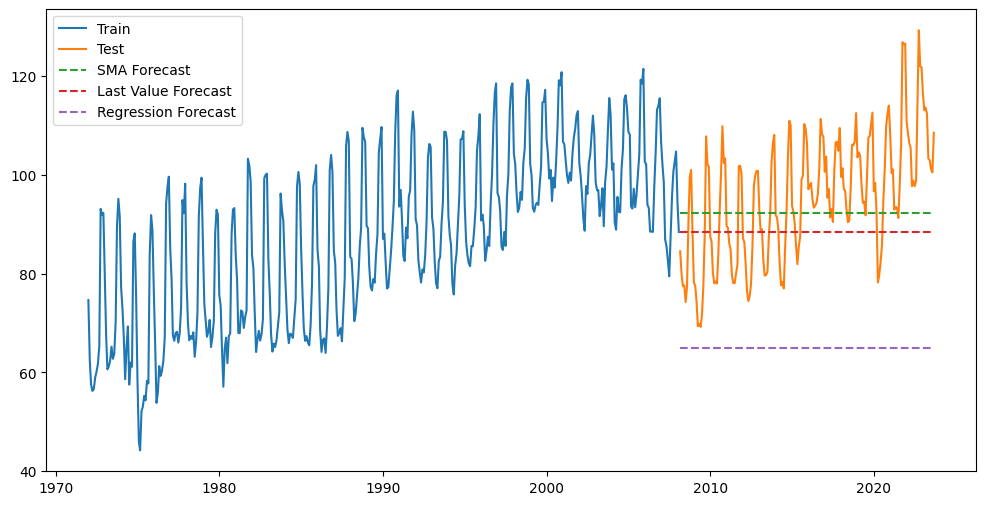

In [25]:
# @title SMA, Last Value & LR
import matplotlib

plt.figure(figsize=(12, 6))
plt.plot(train['IP'], label='Train')
plt.plot(test['IP'], label='Test')
plt.plot(test.index, np.full_like(test['IP'], sma_model), label='SMA Forecast', linestyle='dashed')
plt.plot(test.index, np.full_like(test['IP'], loc_model), label='Last Value Forecast', linestyle='dashed')
test_numeric_dates = matplotlib.dates.date2num(test.index)
regression_predictions = regression_model.predict(test_numeric_dates.reshape(-1, 1))
plt.plot(test_numeric_dates, regression_predictions, label='Regression Forecast', linestyle='dashed')

plt.legend()
plt.show()

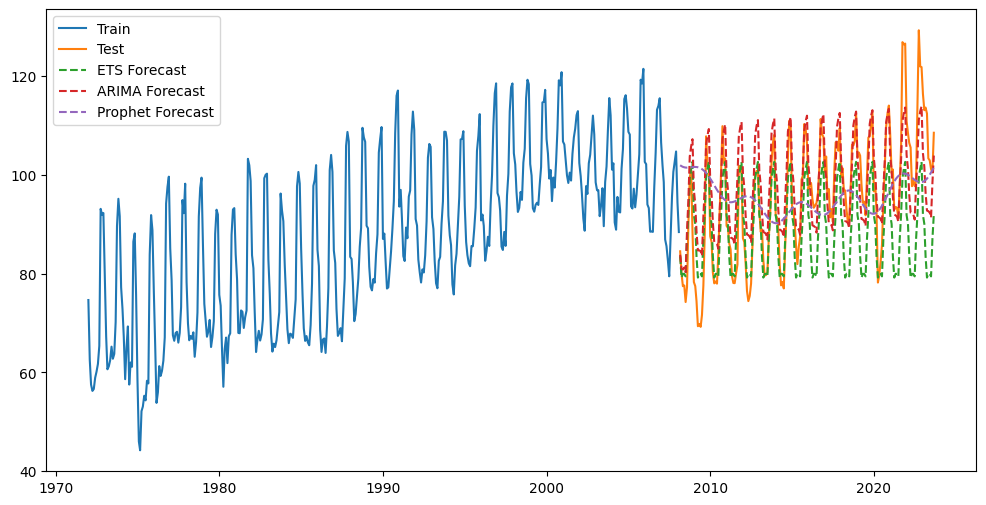

In [26]:
# @title ETS, ARIMA & Prophet
import matplotlib

plt.figure(figsize=(12, 6))
plt.plot(train['IP'], label='Train')
plt.plot(test['IP'], label='Test')
plt.plot(test.index, ets_fit.predict(start=test.index[0], end=test.index[-1]), label='ETS Forecast', linestyle='dashed')
plt.plot(test.index, arima_fit.forecast(len(test)), label='ARIMA Forecast', linestyle='dashed')
plt.plot(test.index, prophet_forecast['yhat'].values[-len(test):], label='Prophet Forecast', linestyle='dashed')
plt.legend()
plt.show()